In [69]:
from PIL import Image

from glob import glob
import requests
import io
import os
import numpy as np
import cv2
import dlib

from matplotlib import gridspec
import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torchvision.transforms import functional as F

## stabilityai/stable-diffusion-xl-refiner-1.0

In [117]:
model_id = "stabilityai/stable-diffusion-2-1"

pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
pipe = pipe.to("cuda")

unet\diffusion_pytorch_model.safetensors not found


Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

RuntimeError: CUDA out of memory. Tried to allocate 30.00 MiB (GPU 0; 12.00 GiB total capacity; 11.09 GiB already allocated; 0 bytes free; 11.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [115]:
image = load_image("./data/001_origin.jpg").convert("RGB")
prompt = "eyes bigger"
outputs = pipe(prompt, image=image).images

RuntimeError: CUDA out of memory. Tried to allocate 872.00 MiB (GPU 0; 12.00 GiB total capacity; 10.69 GiB already allocated; 0 bytes free; 10.86 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

## radames/stable-diffusion-x4-upscaler-img2img

In [3]:
model_id = "stabilityai/stable-diffusion-x4-upscaler"
pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id,torch_dtype=torch.float16)
pipeline = pipeline.to("cuda")

vae\diffusion_pytorch_model.safetensors not found
Cannot initialize model with low cpu memory usage because `accelerate` was not found in the environment. Defaulting to `low_cpu_mem_usage=False`. It is strongly recommended to install `accelerate` for faster and less memory-intense model loading. You can do so with: 
```
pip install accelerate
```
.


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
low_res_img = Image.open("./data/002_origin.jpg").convert("RGB")
low_res_img = low_res_img.resize((128,128))

prompt = "eyes get bigger"

upscaled_iamge = pipeline(prompt=prompt, image=low_res_img).images

  0%|          | 0/75 [00:00<?, ?it/s]

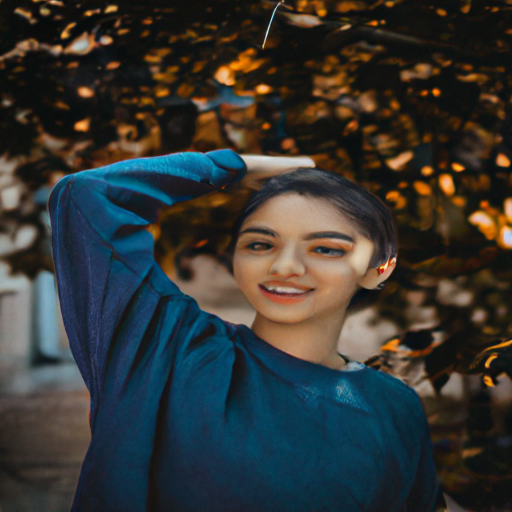

In [11]:
upscaled_iamge[0]

## segmentation

In [1]:
from transformers import SegformerImageProcessor, SegformerForSemanticSegmentation

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
image_processor = SegformerImageProcessor.from_pretrained("jonathandinu/face-parsing")
model = SegformerForSemanticSegmentation.from_pretrained("jonathandinu/face-parsing")
model.to(device)

SegformerForSemanticSegmentation(
  (segformer): SegformerModel(
    (encoder): SegformerEncoder(
      (patch_embeddings): ModuleList(
        (0): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
          (layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        )
        (1): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        )
        (2): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
        )
        (3): SegformerOverlapPatchEmbeddings(
          (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)

In [27]:
def ade_palette():
    """ADE20K palette that maps each class to RGB values."""
    return [
        [125, 237, 123],
        [25, 97, 48],
        [59, 11, 81],
        [163, 123, 42],
        [239, 41, 136],
        [224, 4, 115],
        [114, 84, 169],
        [16, 137, 208],
        [153, 91, 30],
        [48, 90, 221],
        [91, 245, 206],
        [108, 87, 175],
        [232, 181, 231],
        [153, 70, 176],
        [32, 25, 179],
        [118, 177, 239],
        [246, 75, 15],
        [183, 17, 190],
        [79, 235, 51],
    ]

In [36]:
def label_to_color_image(label):
    if label.ndim != 2:
        raise ValueError("Expect 2-D input label")

    if np.max(label) >= len(colormap):
        raise ValueError("label value too large.")
    return colormap[label]

In [112]:
def draw_plot(pred_img, seg):
    fig = plt.figure(figsize=(20, 15))

    grid_spec = gridspec.GridSpec(1, 2, width_ratios=[6, 1])

    plt.subplot(grid_spec[0])
    plt.imshow(pred_img)
    plt.axis("off")
    LABEL_NAMES = np.asarray(labels_list)
    FULL_LABEL_MAP = np.arange(len(LABEL_NAMES)).reshape(len(LABEL_NAMES), 1)
    FULL_COLOR_MAP = label_to_color_image(FULL_LABEL_MAP)

    unique_labels = np.unique(seg.numpy().astype("uint8"))
    ax = plt.subplot(grid_spec[1])
    plt.imshow(FULL_COLOR_MAP[unique_labels].astype(np.uint8), interpolation="nearest")
    ax.yaxis.tick_right()
    plt.yticks(range(len(unique_labels)), LABEL_NAMES[unique_labels])
    plt.xticks([], [])
    ax.tick_params(width=0.0, labelsize=25)
    return fig

In [34]:
labels_list = ["background",
"skin",
"nose",
"r_eye",
"l_eye",
"r_brow",
"l_brow",
"r_ear",
"l_ear",
"mouth",
"u_lip",
"l_lip",
"neck",
"hair",
"neck_l",
"cloth",
"eye_g",
"hat",
'ear_r']

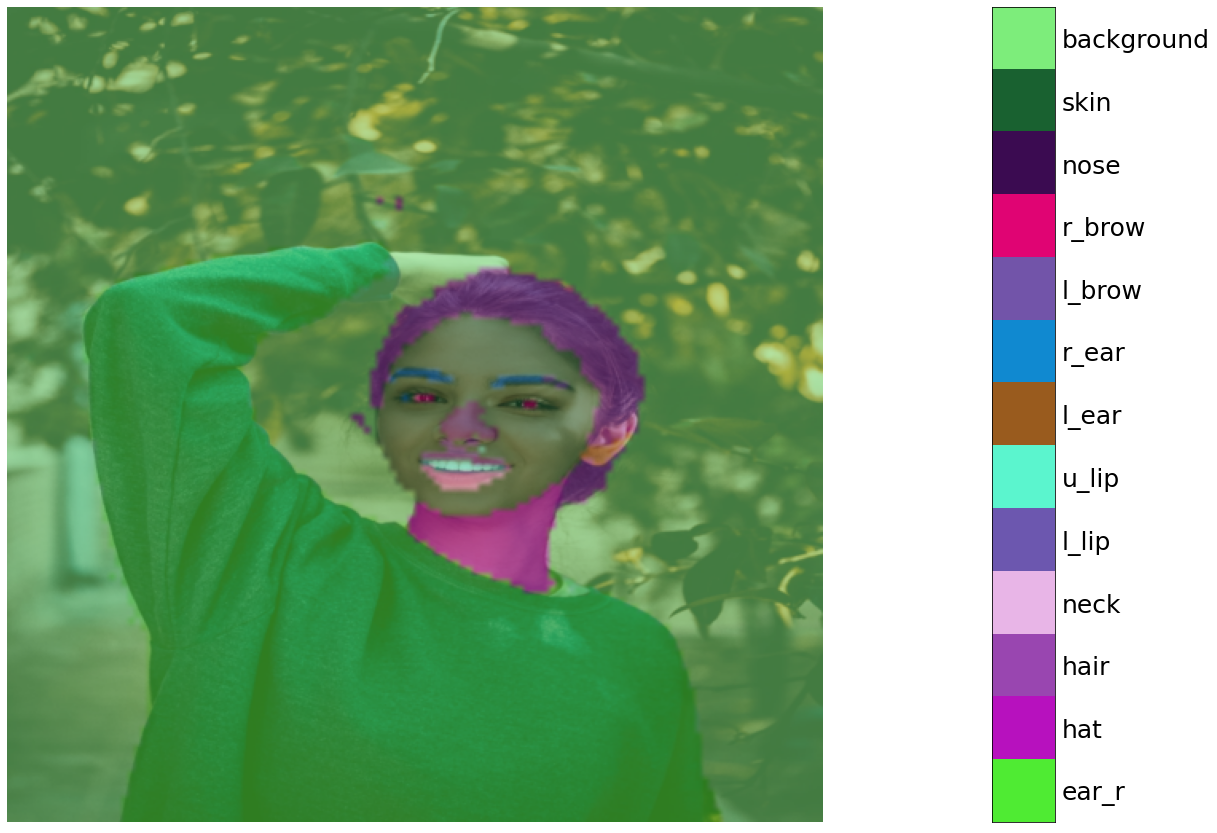

In [129]:
image = Image.open("./data/002_origin.jpg")
pixel_values = F.resize(image, (512,512))

inputs = image_processor(image,return_tensors="pt")

outputs = model(inputs["pixel_values"].to(device))

logits = outputs.logits
seg = logits.argmax(dim=1)[0].cpu()

color_seg = np.zeros(
    (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
)
for label, color in enumerate(colormap) :
    color_seg[seg.numpy() == label, :] = color

color_seg_up = cv2.resize(color_seg,(512,512))
pred_img = np.array(F.resize(image,(512,512)))*0.5 + color_seg_up*0.5
pred_img = pred_img.astype(np.uint8)

fig = draw_plot(pred_img, seg)

tensor(0)


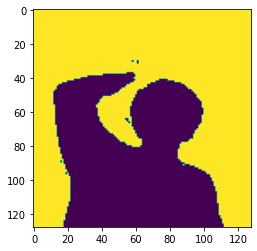

tensor(1)


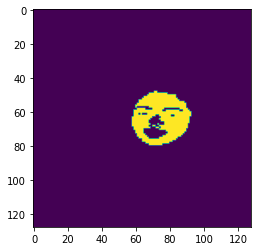

tensor(2)


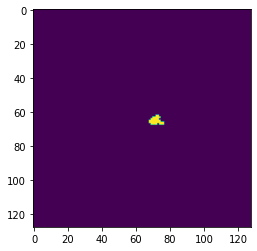

tensor(5)


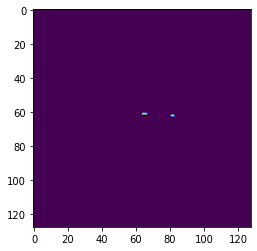

tensor(6)


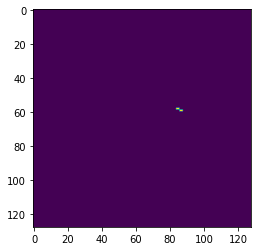

tensor(7)


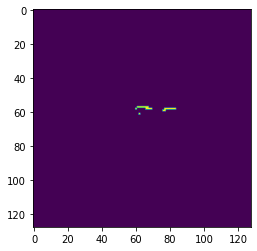

tensor(8)


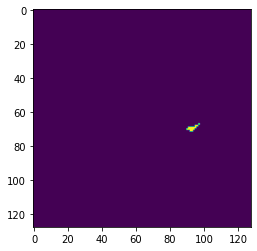

tensor(10)


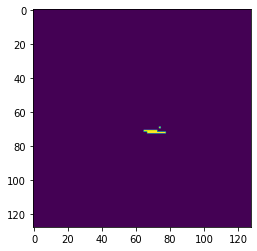

tensor(11)


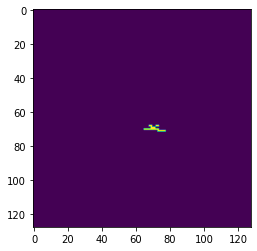

tensor(12)


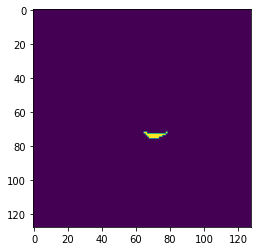

tensor(13)


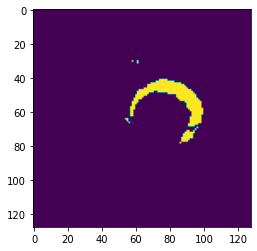

tensor(17)


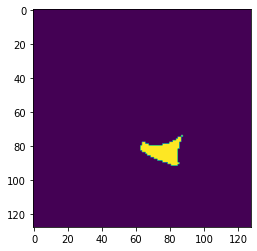

tensor(18)


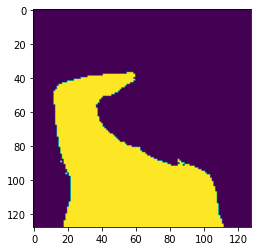

In [130]:
for v in seg.unique() :
    print(v)
    plt.imshow(np.array(seg==v).astype(int))
    plt.show()

## Face Capture

In [70]:
def zoom(image,x1,x2,y1,y2,exp,scale) :
    crop_image = image[x1-10:x2+10,y1-10:y2+10].copy()
    rows,cols = crop_image.shape[:2]
    
    mapy, mapx = np.indices((rows,cols),dtype=np.float32)
    
    mapx = 2*mapx/(cols-1)-1
    mapy = 2*mapy/(rows-1)-1
    
    r,theta = cv2.cartToPolar(mapx, mapy)
    r[r<scale] = r[r<scale]**exp
    
    mapx, mapy = cv2.polarToCart(r,theta)
    
    mapx = ((mapx+1)*cols-1)/2
    mapy = ((mapy+1)*rows-1)/2
    
    distorted = cv2.remap(crop_image,mapx,mapy,cv2.INTER_LINEAR)
    
    zoom_image = image.copy()
    zoom_image[x1-9:x2+9,y1-9:y2+9] = distorted[1:-1,1:-1]
    return zoom_image

In [71]:
def liquify(img, cx1,cy1,x_vec,y_vec,half) :
    cx2, cy2 = cx1-x_vec, cy1-y_vec
    # 대상 영역 좌표와 크기 설정
    x, y, w, h = cx1-half, cy1-half, half*2, half*2
    # 관심 영역 설정
    roi = img[y:y+h, x:x+w].copy()
    out = roi.copy()

    # 관심영역 기준으로 좌표 재 설정
    offset_cx1,offset_cy1 = cx1-x, cy1-y
    offset_cx2,offset_cy2 = cx2-x, cy2-y
    
    # 변환 이전 4개의 삼각형 좌표
    tri1 = [[ (0,0), (w, 0), (offset_cx1, offset_cy1)], # 상,top
            [ [0,0], [0, h], [offset_cx1, offset_cy1]], # 좌,left
            [ [w, 0], [offset_cx1, offset_cy1], [w, h]], # 우, right
            [ [0, h], [offset_cx1, offset_cy1], [w, h]]] # 하, bottom

    # 변환 이후 4개의 삼각형 좌표
    tri2 = [[ [0,0], [w,0], [offset_cx2, offset_cy2]], # 상, top
            [ [0,0], [0, h], [offset_cx2, offset_cy2]], # 좌, left
            [ [w,0], [offset_cx2, offset_cy2], [w, h]], # 우, right
            [ [0,h], [offset_cx2, offset_cy2], [w, h]]] # 하, bottom

    
    for i in range(4):
        # 각각의 삼각형 좌표에 대해 어핀 변환 적용
        matrix = cv2.getAffineTransform( np.float32(tri1[i]), \
                                         np.float32(tri2[i]))
        warped = cv2.warpAffine( roi.copy(), matrix, (w, h), \
            None, flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)
        # 삼각형 모양의 마스크 생성
        mask = np.zeros((h, w), dtype = np.uint8)
        cv2.fillConvexPoly(mask, np.int32(tri2[i]), (255,255,255))
        
        # 마스킹 후 합성
        warped = cv2.bitwise_and(warped, warped, mask=mask)
        out = cv2.bitwise_and(out, out, mask=cv2.bitwise_not(mask))
        out = out + warped

    # 관심 영역을 원본 영상에 합성
    img[y:y+h, x:x+w] = out
    return img 

In [72]:
class CFG :
    eye_ratio = 1.2 # 눈 확대 비율 (축소: 0.1~1.0, 확대: 1.1~)
    eye_scale = 1.  # 눈 확대 영역 크기
    
    left_nose = 8   # 왼쪽 콧볼 축소 비율
    right_nose = 8  # 오른쪽 콧볼 축소 비율
    nose_ratio = 70 # 콧볼 성형 비율
config = CFG()

In [77]:
def face_collect(image:str,config:CFG) :
    '''
    path: 이미지가 저장된 경로
        ex) path = "./data/001_origin.jpg"
    config: 성형 비율 파라미터 값
    '''
    detector = dlib.get_frontal_face_detector()
    predictor = dlib.shape_predictor('shape_predictor_68_face_landmarks.dat')

    ALL = list(range(0, 68))
    RIGHT_EYEBROW = list(range(17, 22)) 
    LEFT_EYEBROW = list(range(22, 27)) 
    RIGHT_EYE = list(range(36, 42)) 
    LEFT_EYE = list(range(42, 48)) 
    NOSE = list(range(27, 36)) 
    MOUTH_OUTLINE = list(range(48, 61)) 
    MOUTH_INNER = list(range(61, 68))
    JAWLINE = list(range(0, 17))

    index = ALL

    image = cv2.imread(path)
    image_lst.append(image)

    result = image.copy()
    img_gray = cv2.cvtColor(result,cv2.COLOR_BGR2GRAY)

    dets = detector(img_gray)

    for face in dets :
        shape = predictor(result, face)

        list_points = []
        for p in shape.parts() :
            list_points.append([p.x,p.y])

        list_points = np.array(list_points)

    # Change Right Eye
    y1,x1 = np.min(list_points[RIGHT_EYE],axis=0)
    y2,x2 = np.max(list_points[RIGHT_EYE],axis=0)
    result_right = zoom(result,x1,x2,y1,y2,exp=config.eye_ratio,scale=config.eye_scale)

    # Change Left Eye
    y1,x1 = np.min(list_points[LEFT_EYE],axis=0)
    y2,x2 = np.max(list_points[LEFT_EYE],axis=0)
    result_eye = zoom(result_right,x1,x2,y1,y2,exp=config.eye_ratio,scale=config.eye_scale)

    # Change nose
    x1,_ = np.min(list_points[NOSE],axis=0)
    x2,y = np.max(list_points[NOSE],axis=0)
    result_left_nose = liquify(result_eye,x1,y,-config.left_nose,0,config.nose_ratio)
    result = liquify(result_left_nose,x2,y,config.right_nose,0,config.nose_ratio)
    
    return result

In [80]:
path_lst = glob("./data/*_origin.jpg")
for i,path in enumerate(path_lst) :
    result = face_collect(path,config)
    cv2.imwrite(f"./data/00{i+1}_result_make.jpg",result)